# Used Packages

In [1]:
import os
import glob
import gc

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from scipy.spatial.transform import Rotation as R

from utils.MovingAverager import *
from collections import defaultdict
from torchinfo import summary

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

# Global Variable

In [2]:
rotation = False
num_of_axie = 3

datapoint_per_second = 20
duration = 2
seq_len = 10

In [3]:
validation_traj = np.load(f'./all_user_match_data.npy', allow_pickle=True)

In [4]:
valid_data = validation_traj.item()
pose_set = set()
for user_name in valid_data.keys():
    for path_name in valid_data[user_name].keys():
        for posture_name in valid_data[user_name][path_name].keys():
            pose_set.add(posture_name)
print(pose_set)

{'front_pocket', 'swing', 'target', 'horizontal', 'pocket', 'ref_mag'}


In [5]:
def estimate_gravity(gravity_included_acceleration, dynamic_acceleration):
    raw_gravity_vector = np.array(gravity_included_acceleration) - np.array(dynamic_acceleration)
    gravity_direction = raw_gravity_vector / np.linalg.norm(raw_gravity_vector)
    return gravity_direction

In [6]:
def align_magnetometer_with_gravity(magnetometer_data, gravity_direction):
    target_gravity_direction = np.array([0, 0, 1])
    rotation_vector = np.cross(gravity_direction, target_gravity_direction)
    rotation_vector_magnitude = np.linalg.norm(rotation_vector)
    if rotation_vector_magnitude == 0:
        return magnetometer_data  # 如果已经对齐，则不需要旋转
    rotation_vector /= rotation_vector_magnitude
    angle = np.arccos(np.dot(gravity_direction, target_gravity_direction))
    rotation = R.from_rotvec(rotation_vector * angle[:, np.newaxis])
    rotated_magnetometer_data = rotation.apply(magnetometer_data)
    vh = np.column_stack((np.sqrt(rotated_magnetometer_data[:, 0]**2 + rotated_magnetometer_data[:, 1]**2), rotated_magnetometer_data[:, 2]))
    return vh if num_of_axis == 2 else rotated_magnetometer_data

In [7]:
posture_data = defaultdict(list)

valid_data = validation_traj.item()
for user_name in valid_data.keys():
    for path_name in valid_data[user_name].keys():
        for posture_name in valid_data[user_name][path_name].keys():
            data = valid_data[user_name][path_name][posture_name]
            
            if posture_name == 'ref_mag':
                posture_data[posture_name].append(data[:, [0, 1, 2, 3, 4, 6, 7, 5]])
                continue
            
            pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
            imu = data[:, [3, 4, 5, 6, 7, 8, 9, 10, 11]]
            mag = data[:, [12, 13, 14]]

            pos_mag = np.concatenate((pos, imu), axis=-1)
            
            if rotation:
                gravity_direction = estimate_gravity(imu[:, 0:3], imu[:, 3:6])
                mag = align_magnetometer_with_gravity(mag[:, 0:3], gravity_direction)
            else:
                if num_of_axie == 2: 
                    mag = np.column_stack((np.sqrt(np.sum(data[:, :2]**2, axis=1)), mag[:, 2]))
            pos_mag = np.concatenate((pos_mag, mag, data[:, [15]]), axis=-1)            
            posture_data[posture_name].append(pos_mag)

In [8]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [9]:
prep_valid_traj = defaultdict(np.array)

prep_valid_traj['front_pocket'] = split_traj(posture_data['front_pocket'])
prep_valid_traj['horizontal']   = split_traj(posture_data['horizontal'])
prep_valid_traj['pocket']       = split_traj(posture_data['pocket'])
prep_valid_traj['swing']        = split_traj(posture_data['swing'])
prep_valid_traj['target']       = split_traj(posture_data['target'])
prep_valid_traj['ref_mag']      = split_traj(posture_data['ref_mag'])

In [10]:
for key, value in prep_valid_traj.items():
    print(f'{key:>15} shape: {value.shape}')

   front_pocket shape: (674, 20, 15)
     horizontal shape: (674, 20, 15)
         pocket shape: (674, 20, 15)
          swing shape: (674, 20, 15)
         target shape: (674, 20, 15)
        ref_mag shape: (674, 20, 8)


In [11]:
datapoint_per_second = 20
duration = 2
seq_len = 10

# Data Loader

In [12]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        assert (source_data.shape[0] == source_label.shape[0] == target_data.shape[0] == target_label.shape[0]), f'{source_data.shape}, {source_label.shape}, {target_data.shape}, {target_label.shape}'
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [13]:
def for_dataloaders(traj, gt='target'):
    t_data = 0
    t_label = 0
    t_target_data = 0
    v_data = 0
    v_label = 0
    v_target_data = 0
    label = 1
    label_dict = {}
    flag = False
    for key, value in traj.items():
        tmp1, tmp2 = value[0::2], value[1::2]
        if key != gt: 
            t_data = np.concatenate((t_data, tmp1)) if flag else tmp1
            t_label = np.concatenate((t_label, np.full((tmp1.shape[0], ), label))) if flag else np.full((tmp1.shape[0], ), label)
            v_data = np.concatenate((v_data, tmp2)) if flag else tmp2
            v_label = np.concatenate((v_label, np.full((tmp2.shape[0], ), label))) if flag else np.full((tmp2.shape[0], ), label)
            flag = True
            label_dict[label] = key
            label += 1
        else:
            t_target_data = np.tile(tmp1, (4, 1, 1))
            v_target_data = np.tile(tmp2, (4, 1, 1))
            label_dict[0] = key
    
    train_dataset = PairDataset(
                        source_data = torch.tensor(t_data, dtype=torch.float),
                        source_label = t_label,
                        target_data = torch.tensor(t_target_data, dtype=torch.float),
                        target_label = np.zeros((len(t_target_data), ))
                    )
    
    valid_dataset = PairDataset(
                        source_data = torch.tensor(v_data, dtype=torch.float),
                        source_label = v_label,
                        target_data = torch.tensor(v_target_data, dtype=torch.float),
                        target_label = np.zeros((len(v_target_data), ))
                    )

    print(label_dict)
    return label_dict, train_dataset, valid_dataset

In [14]:
classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt='target')

{1: 'front_pocket', 2: 'horizontal', 3: 'pocket', 4: 'swing', 0: 'target'}


In [15]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

# Model Declaration

In [16]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [17]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, source_total_mag, target_total_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)
    
    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))
    
    smag_limitation_loss = torch.mean(torch.abs(pred_total_mag - source_total_mag))
    tmag_limitation_loss = torch.mean(torch.abs(pred_total_mag - target_total_mag))

    total_loss = imu_loss + mag_loss + d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

In [18]:
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [19]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    return mask

In [20]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        self.mag_axis = num_of_axie
        
        self.imu_layer = nn.Sequential(
            nn.Linear(9, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(self.mag_axis, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 9),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, self.mag_axis),
        )
        
    def forward(self, source_imu, source_mag):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        pred_latent = self.decoder(h_mag, z)
        pred_mag = self.mag_last(pred_latent)
        
        return z_imu, pred_mag

In [21]:
# model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

In [22]:
# summary(model, input_size=[(1, 10, 9), (1, 10, 2)])

In [23]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, num_of_axie)
    targ_mag = result[1].reshape(-1, num_of_axie)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'][:num_of_axie], ['tab:blue', 'tab:orange', 'tab:green'][:num_of_axie]):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [24]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 2:11] + torch.randn_like(source_data[:, :, 2:11]) * 0.25
        source_mag = source_data[:, :, 11:(11 + num_of_axie)] + torch.randn_like(source_data[:, :, 11:(11 + num_of_axie)]) * 0.5
        source_total_mag = source_data[:, :, -1]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, 2:11]
        target_mag = target_data[:, :, 11:(11 + num_of_axie)]
        target_total_mag = target_data[:, :, -1]

        # generate mag
        z_imu, predict_mag = model(source_imu, source_mag)
        
        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                              source_total_mag, target_total_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [25]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axie)]
            source_total_mag = source_data[:, :, -1]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, 2:11]
            target_mag = target_data[:, :, 11:(11 + num_of_axie)]
            target_total_mag = target_data[:, :, -1]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                                  source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [31]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 2:11]
            source_mag = source_data[:, :, 11:(11 + num_of_axie)]

            target_data = target_data.to(device)
            target_pos = target_data[:, :, :2]
            target_imu = target_data[:, :, 2:11]
            target_mag = target_data[:, :, 11:(11 + num_of_axie)]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_pos = target_pos.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label, target_pos))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, num_of_axie) - target_mag.reshape(len(target_mag), -1, num_of_axie), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [27]:
def show_result(model, dataloader):
    results, cres, clabel = output_eval(model, dataloader)
    print(results.shape, cres.shape, clabel.shape)

    if num_of_axie == 3:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy, dz = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
        dx, dy, dz = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
    
    elif num_of_axie == 2:
        print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"avg":>8}')
        for class_label, class_name in classes.items():
            if sum(clabel == class_label) <= 0:
                continue
            dx, dy = cres[clabel == class_label].mean(axis=0)
            print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')
        dx, dy = cres.mean(axis=0)
        print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {np.mean([dx, dy]):>8.2f}')

    for rs in results[::500]:
        plot_result(rs)

# Experiment 1
rotation = False
num_of_axie = 2Different final ground truth (最終姿態)

In [28]:
rotation = False
num_of_axie = 3
gt = 'target'

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

{1: 'front_pocket', 2: 'horizontal', 3: 'pocket', 4: 'swing', 0: 'target'}


100%|██████████████████████████████████████████████████████████████████████████▉| 19999/20000 [2:52:35<00:00,  1.79it/s]

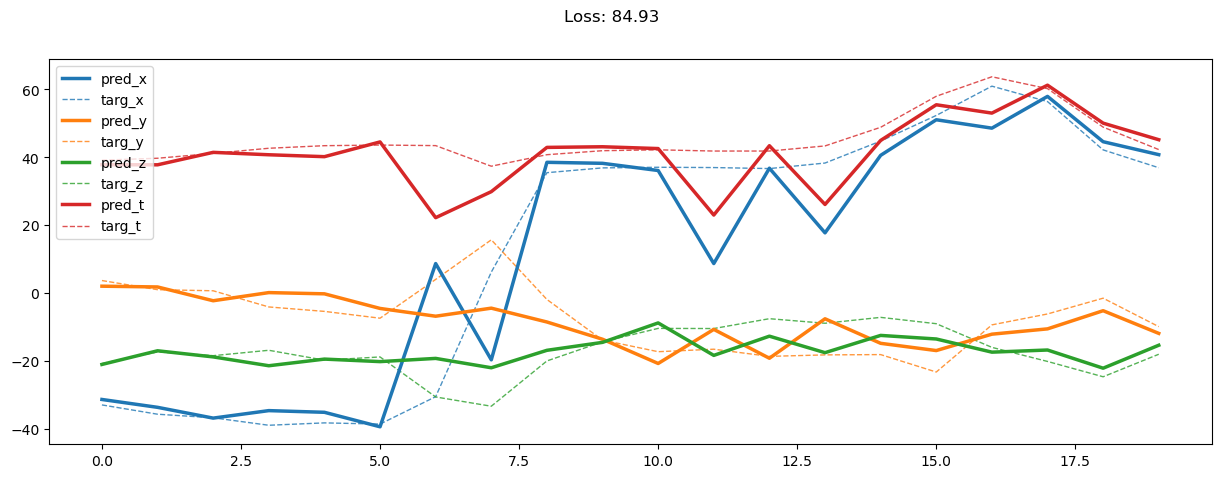

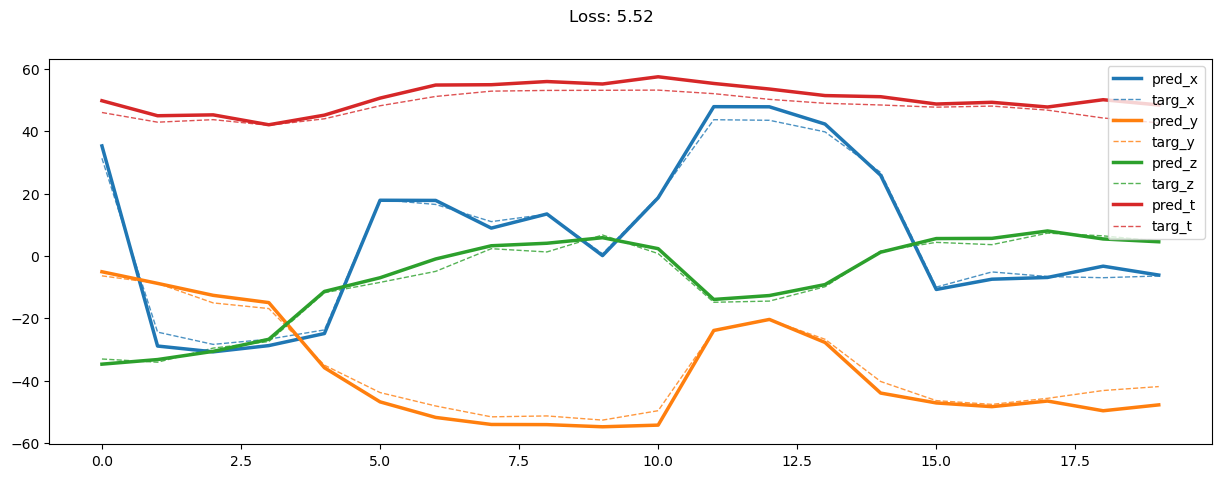

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [2:52:36<00:00,  1.93it/s]

19999: train loss: 84.144, imu loss:  0.470, mag loss: 27.174, div loss: 53.392, slim:  4.670, tlim:  2.588
       valid loss: 34.948, imu loss:  0.440, mag loss: 11.323, div loss: 20.403, slim:  4.391, tlim:  2.246


In [29]:
EPOCH = 20000
draw = False

for epoch in tqdm(range(EPOCH)):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    draw = ((epoch + 1) % 20000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    
    if (epoch + 1) % 20000 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>6.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>6.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

(1348, 4) (1348, 3) (1348,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    14.87    10.46     5.65    10.33
     horizontal loss:    23.36    14.40     7.63    15.13
         pocket loss:    17.01     8.71     5.97    10.57
          swing loss:     7.31     5.99     4.00     5.77
        average loss:    15.64     9.89     5.81    10.45


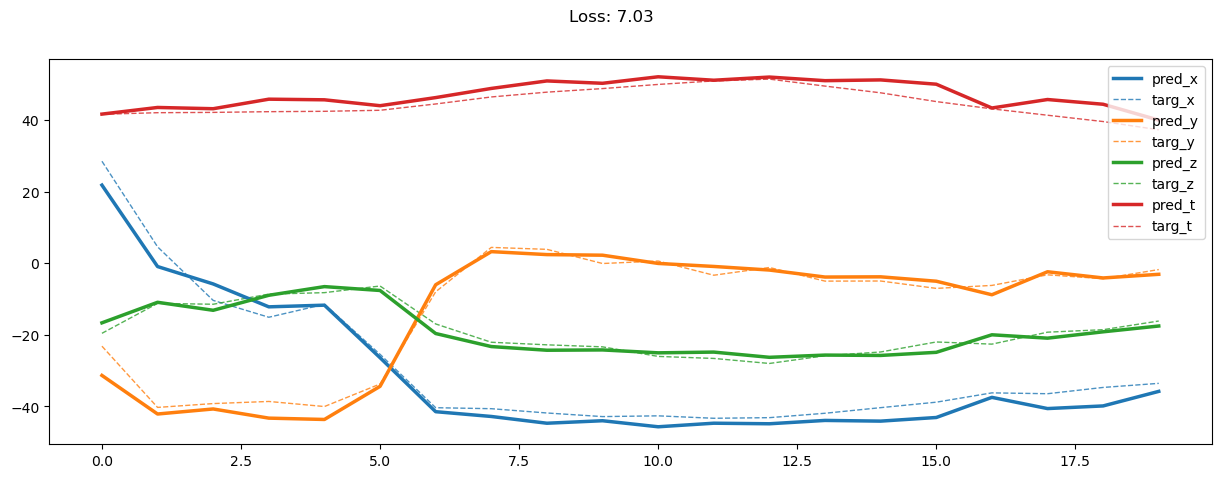

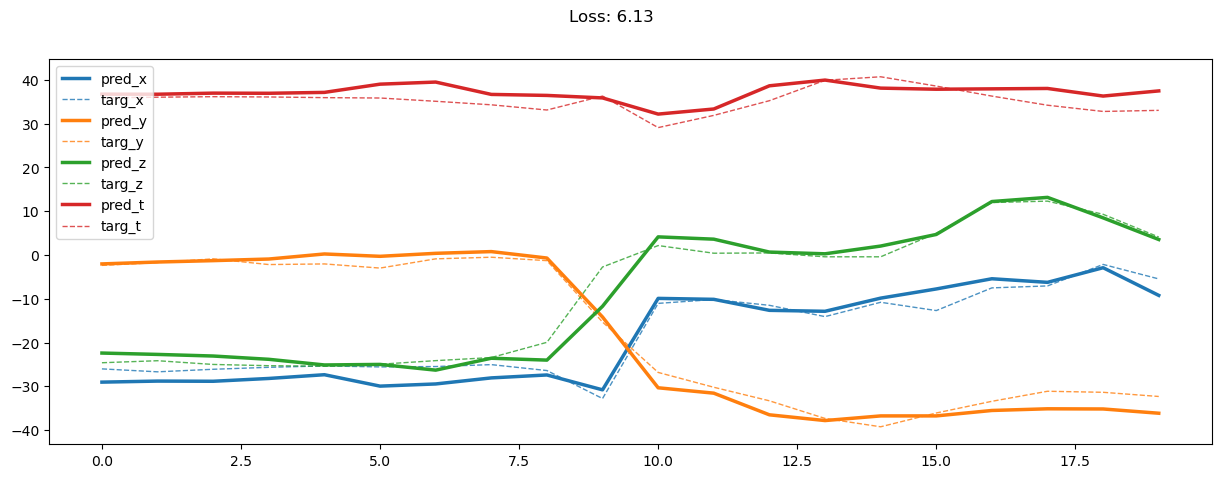

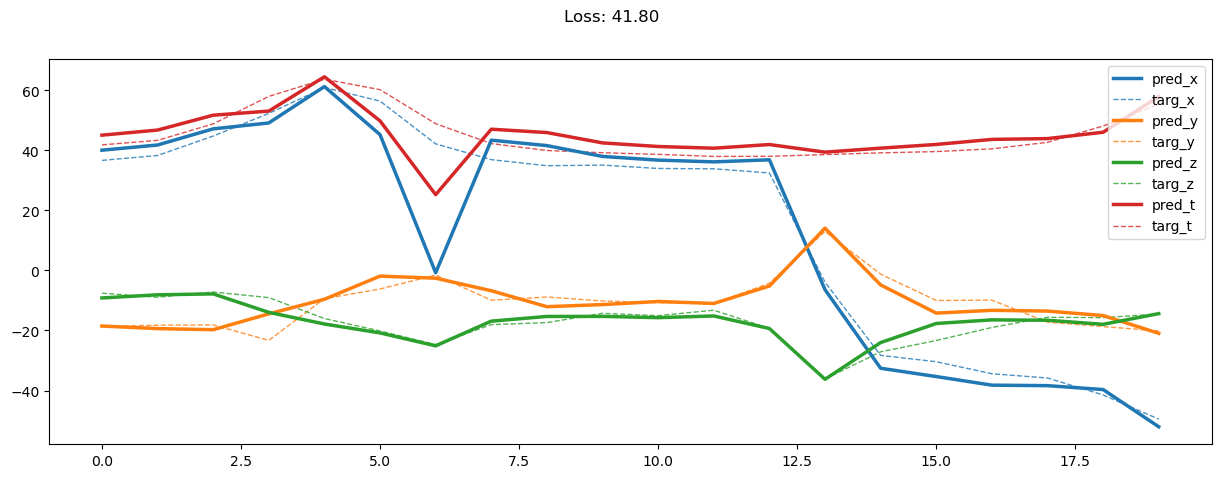

In [32]:
show_result(model, train_loader)

(1348, 4) (1348, 3) (1348,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    15.87    10.50     5.90    10.76
     horizontal loss:    24.31    15.36     7.91    15.86
         pocket loss:    20.95     9.89     6.45    12.43
          swing loss:     8.45     6.52     4.32     6.43
        average loss:    17.40    10.57     6.15    11.37


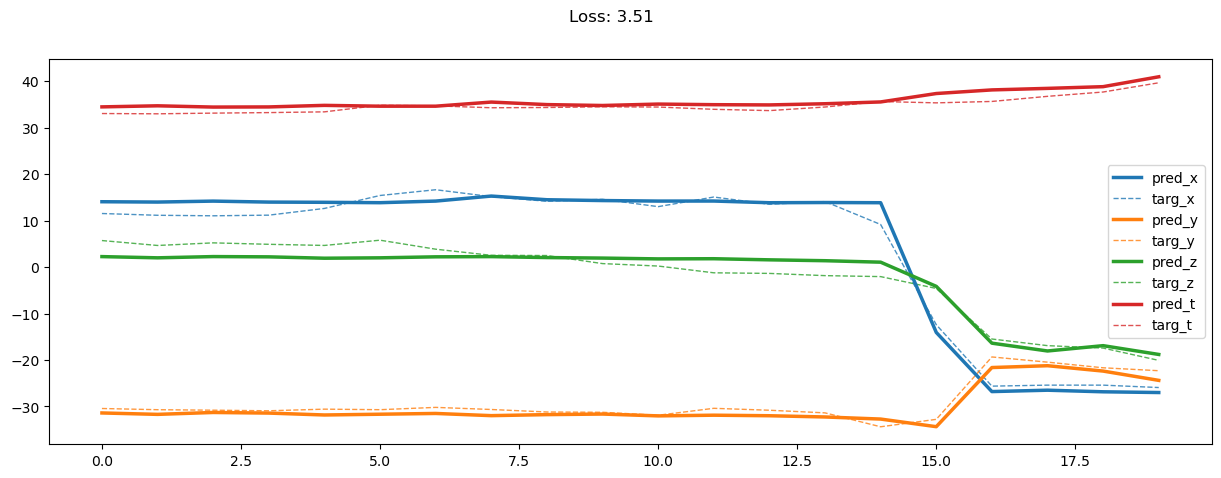

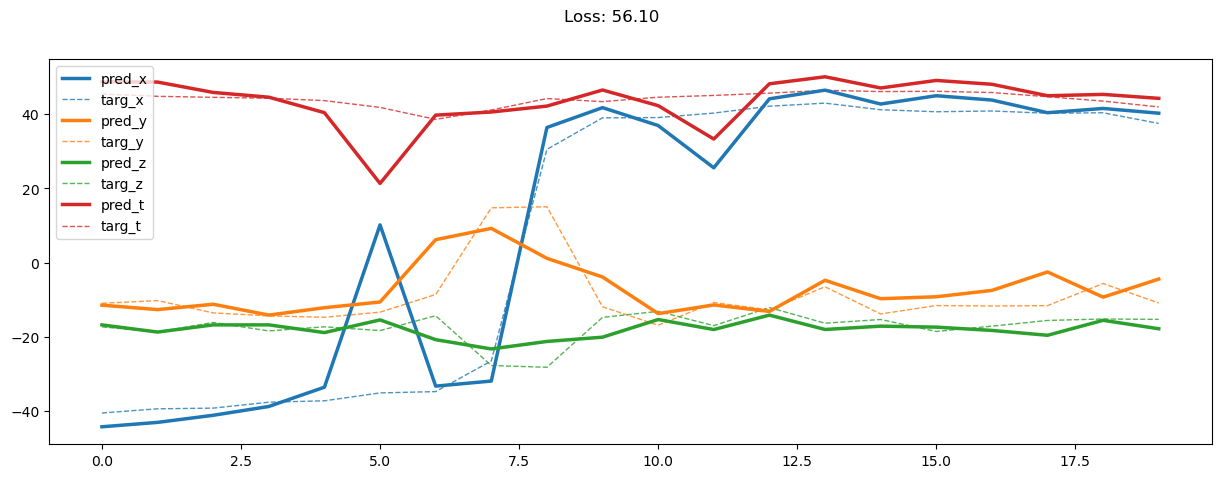

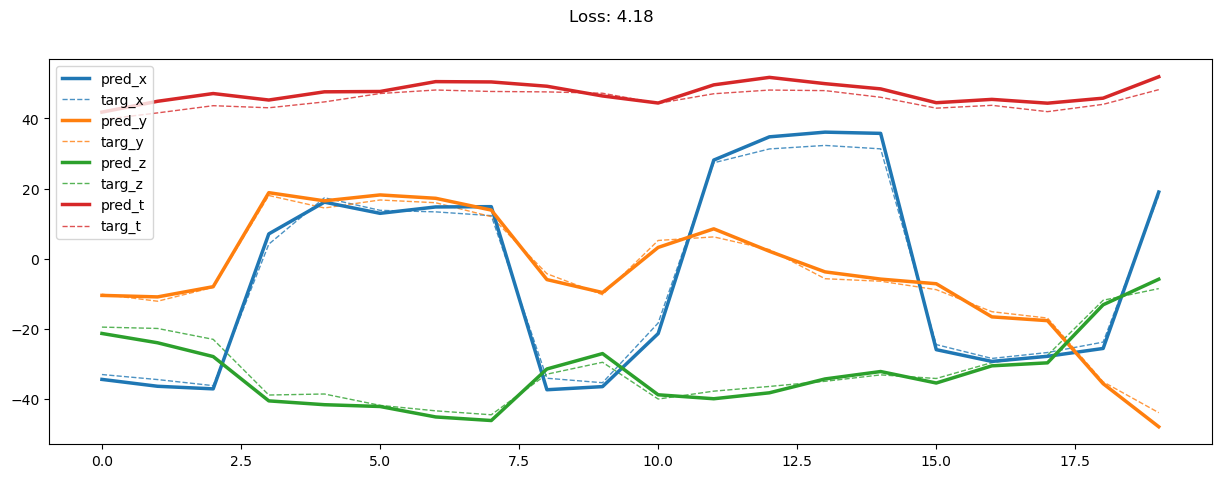

In [33]:
show_result(model, valid_loader)

In [47]:
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

In [48]:
rotation = False
num_of_axie = 3
gt = 'horizontal'

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

{1: 'front_pocket', 0: 'horizontal', 2: 'pocket', 3: 'swing', 4: 'target'}


100%|██████████████████████████████████████████████████████████████████████████▉| 19999/20000 [2:45:39<00:00,  1.80it/s]

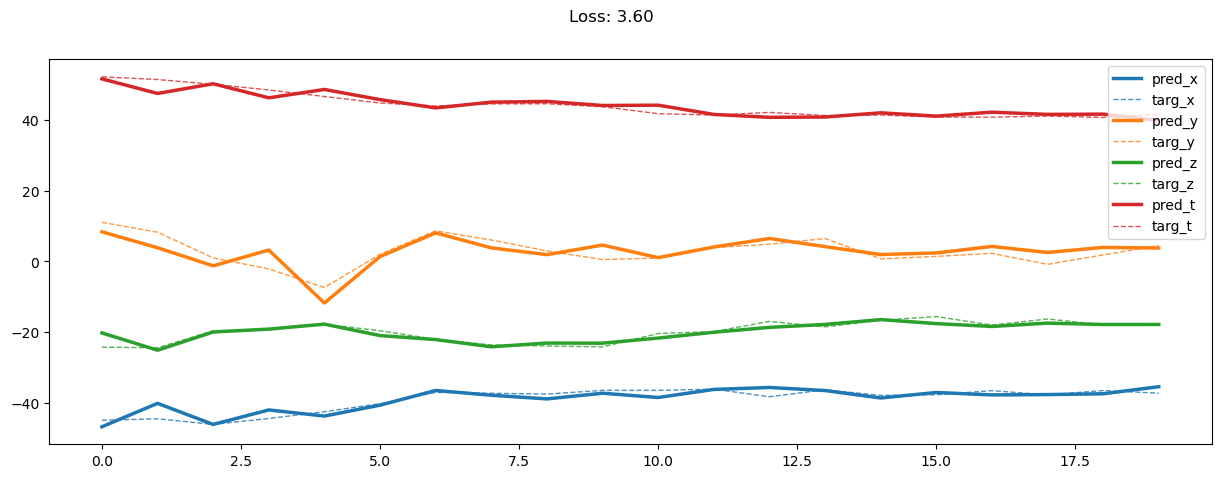

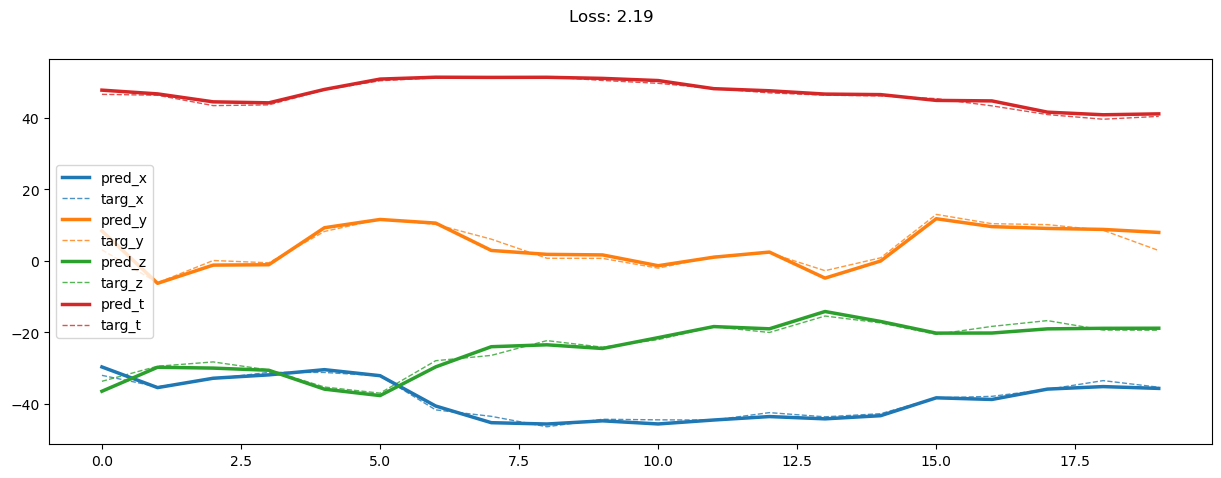

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [2:45:40<00:00,  2.01it/s]

19999: train loss: 18.701, imu loss:  0.434, mag loss:  5.462, div loss: 10.901, slim:  3.727, tlim:  1.297
       valid loss: 10.022, imu loss:  0.381, mag loss:  2.800, div loss:  5.142, slim:  4.023, tlim:  0.925


In [49]:
EPOCH = 20000
draw = False

for epoch in tqdm(range(EPOCH)):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    draw = ((epoch + 1) % 20000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    
    if (epoch + 1) % 20000 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>6.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>6.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

(1348, 4) (1348, 3) (1348,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     2.35     4.42     1.94     2.90
         pocket loss:     2.00     3.88     1.87     2.58
          swing loss:     1.86     2.63     1.44     1.97
         target loss:     2.45     5.07     2.23     3.25
        average loss:     2.16     4.00     1.87     2.68


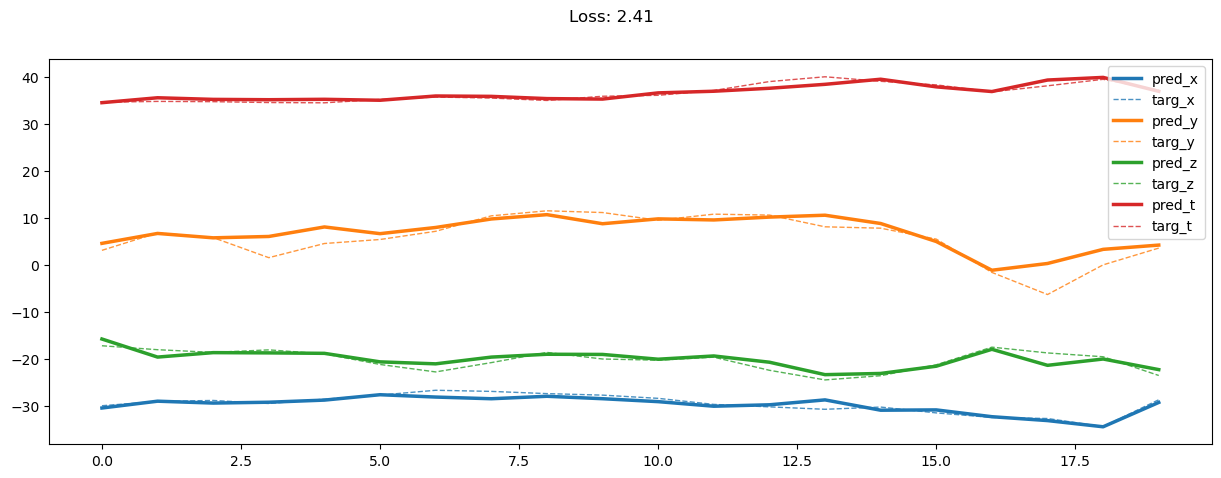

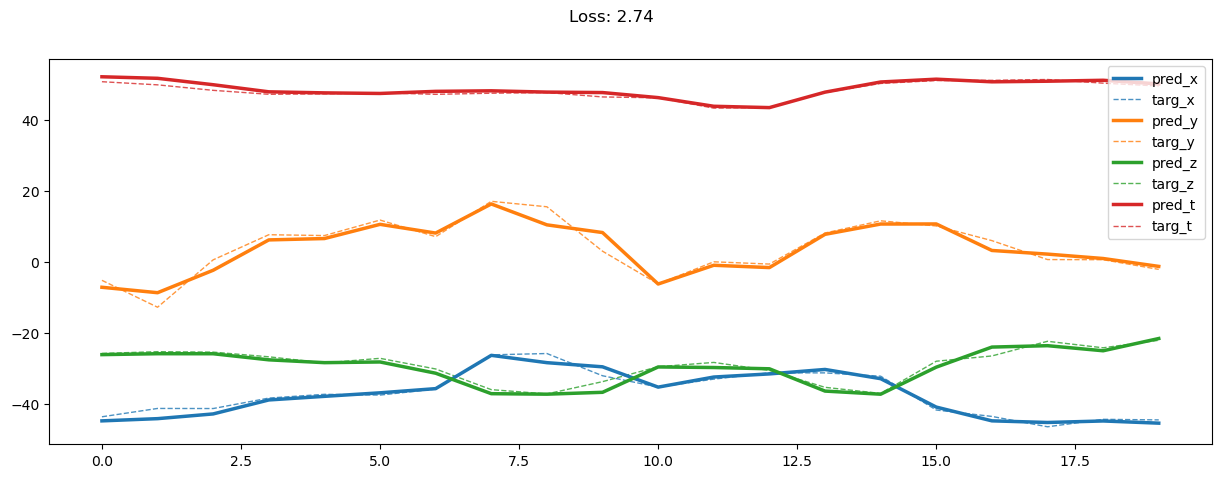

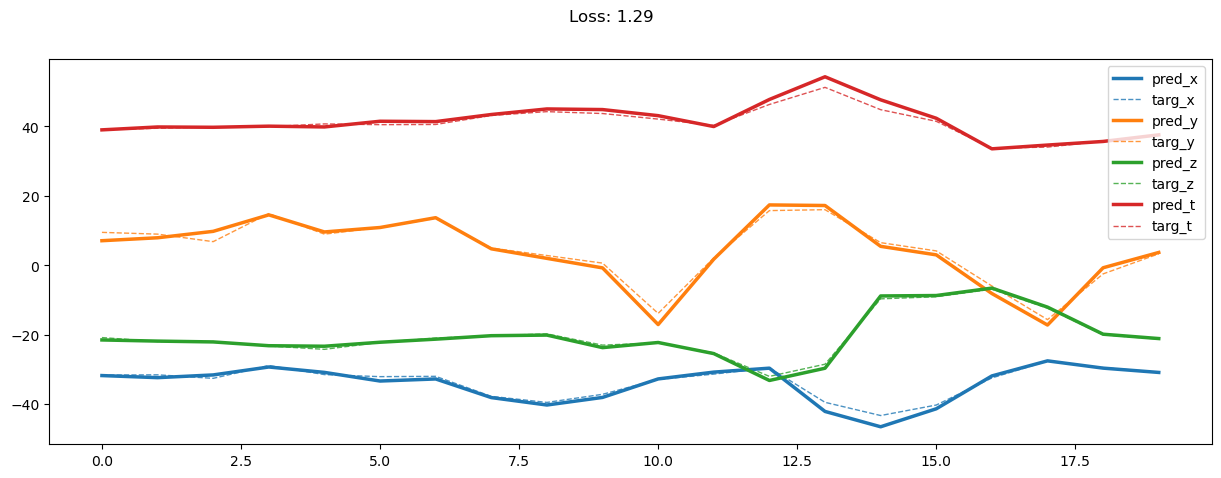

In [50]:
show_result(model, train_loader)

(1348, 4) (1348, 3) (1348,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     2.43     4.52     1.98     2.98
         pocket loss:     2.31     4.46     2.10     2.96
          swing loss:     1.94     2.69     1.52     2.05
         target loss:     2.53     5.16     2.30     3.33
        average loss:     2.30     4.21     1.97     2.83


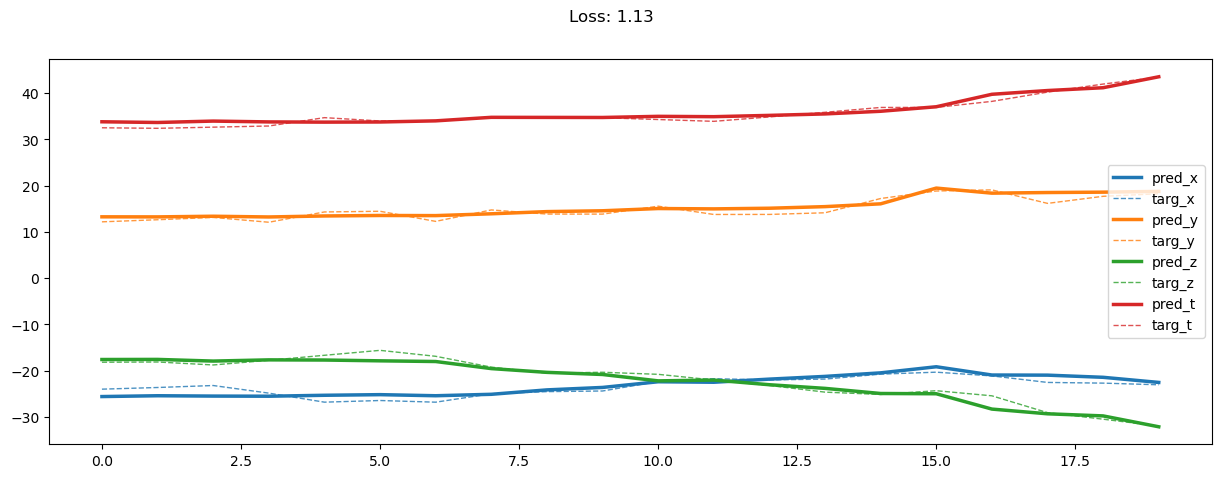

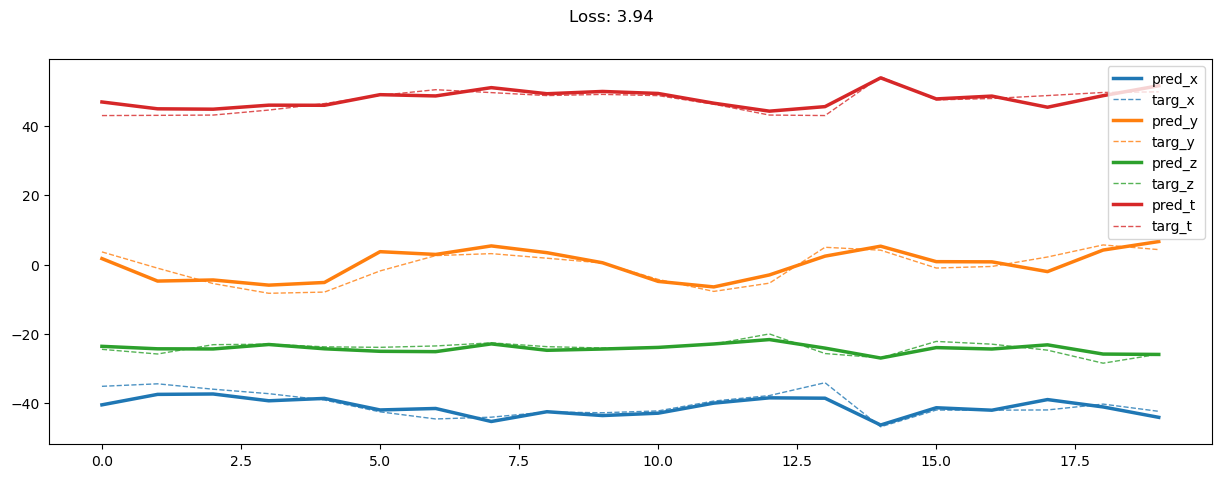

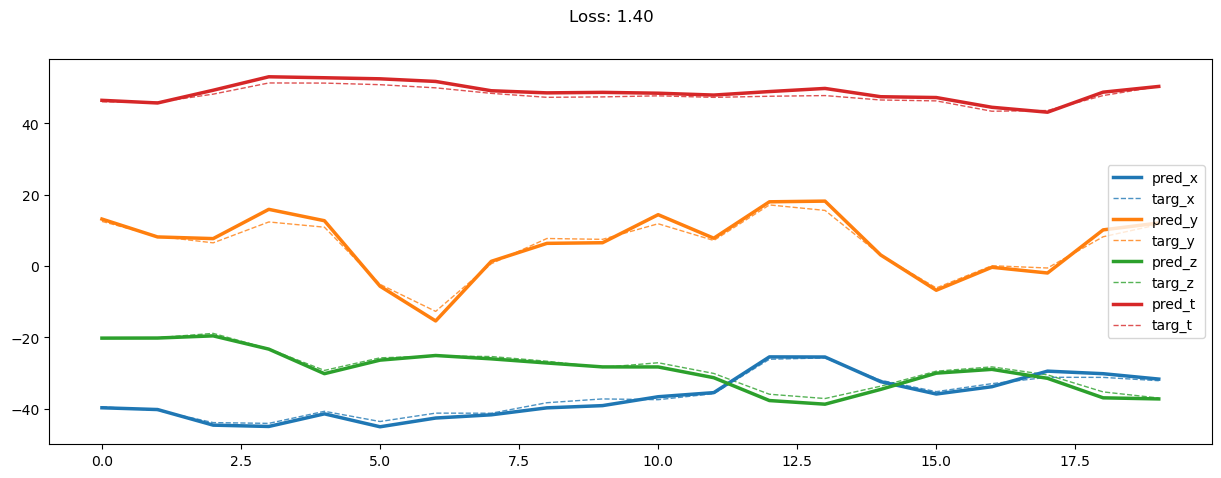

In [51]:
show_result(model, valid_loader)

In [52]:
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

In [53]:
rotation = False
num_of_axie = 3
gt = 'front_pocket'

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

{0: 'front_pocket', 1: 'horizontal', 2: 'pocket', 3: 'swing', 4: 'target'}


100%|██████████████████████████████████████████████████████████████████████████▉| 19999/20000 [2:47:00<00:00,  5.16it/s]

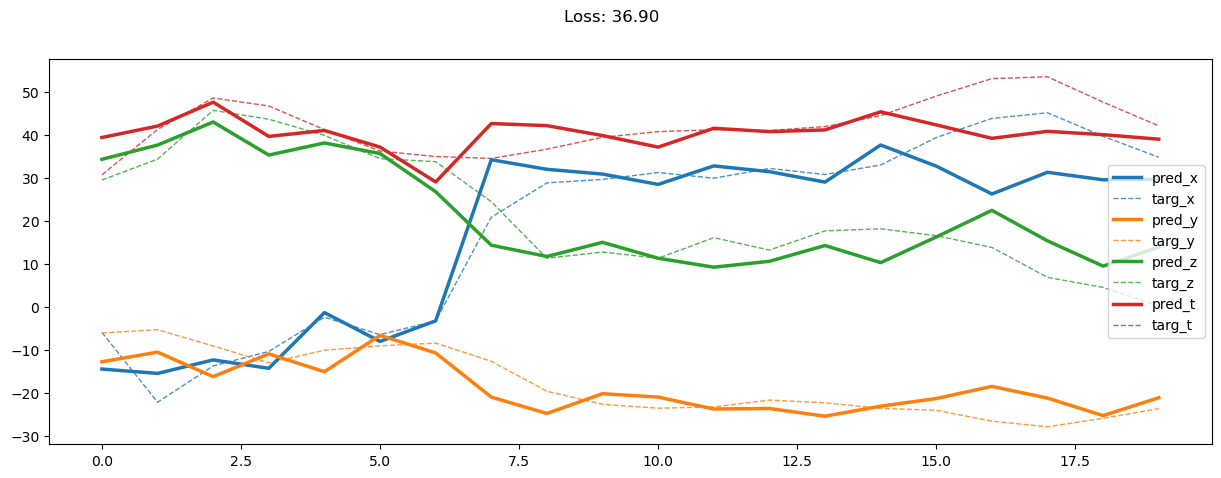

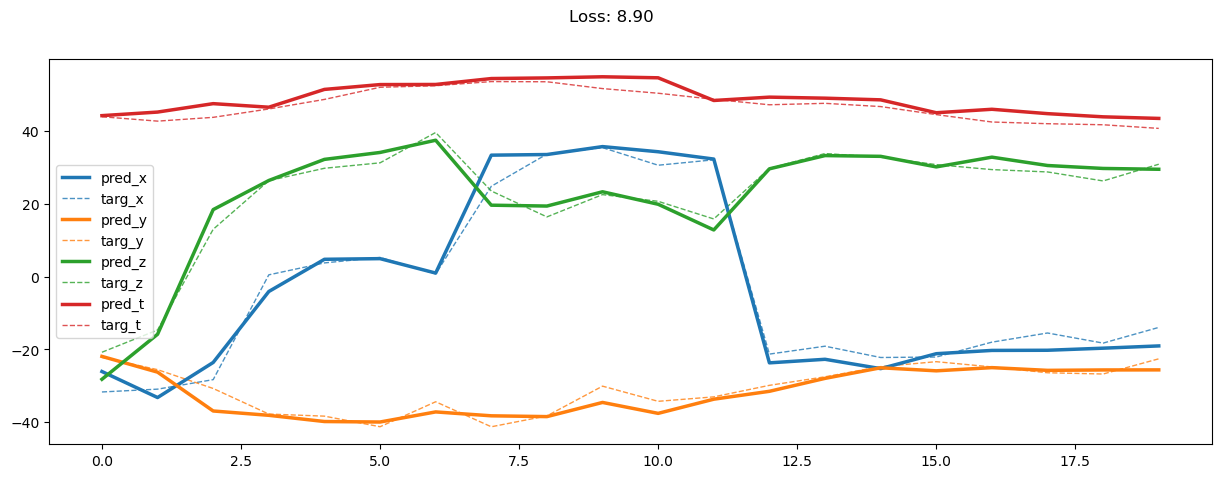

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [2:47:00<00:00,  2.00it/s]

19999: train loss: 72.751, imu loss:  0.578, mag loss: 23.357, div loss: 46.038, slim:  4.027, tlim:  2.360
       valid loss: 32.566, imu loss:  0.562, mag loss: 10.486, div loss: 19.132, slim:  3.796, tlim:  1.916


In [54]:
EPOCH = 20000
draw = False

for epoch in tqdm(range(EPOCH)):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    draw = ((epoch + 1) % 20000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    
    if (epoch + 1) % 20000 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>6.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>6.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

(1348, 4) (1348, 3) (1348,)
           loss name|   diff x   diff y   diff z      avg
     horizontal loss:    20.80     3.77    17.70    14.09
         pocket loss:    10.77     3.24     8.67     7.56
          swing loss:     6.01     3.09     6.64     5.25
         target loss:    21.83     2.94    12.00    12.26
        average loss:    14.85     3.26    11.25     9.79


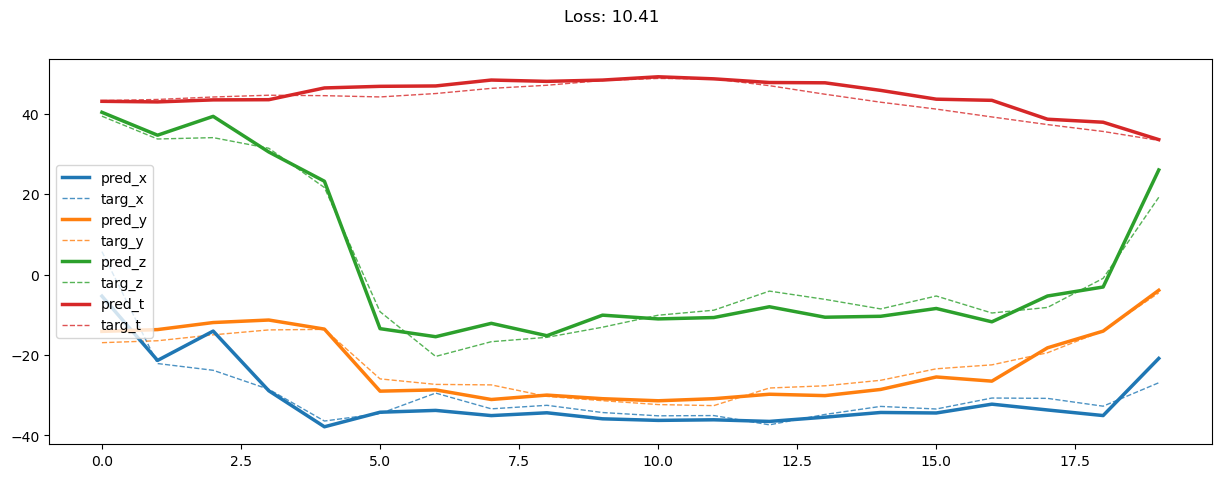

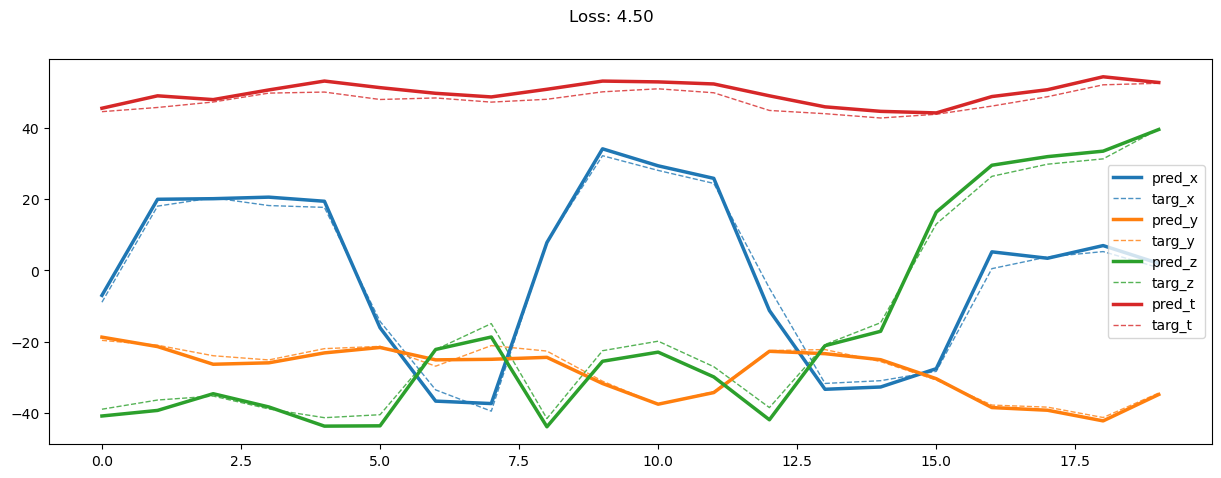

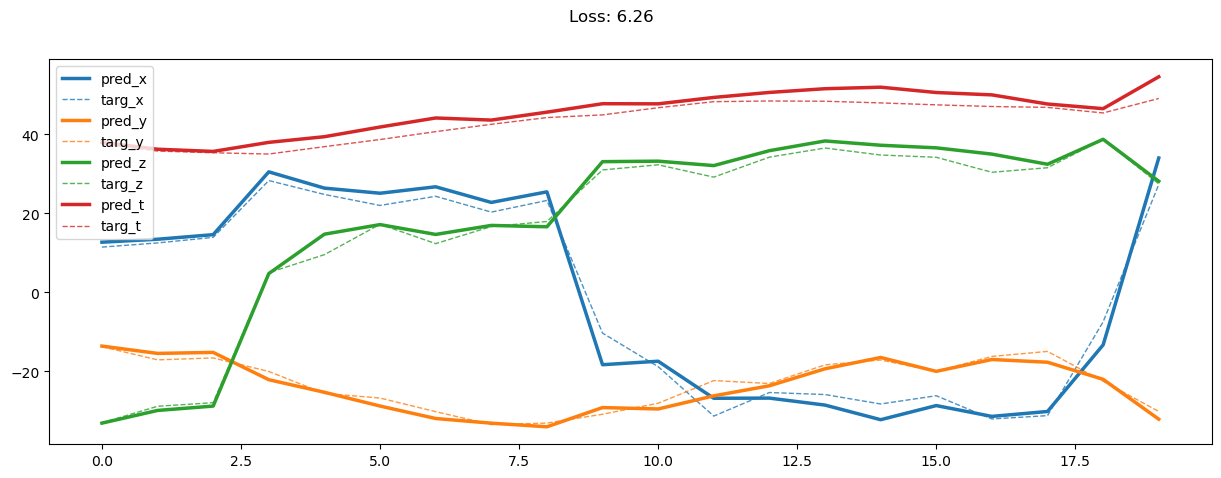

In [55]:
show_result(model, train_loader)

(1348, 4) (1348, 3) (1348,)
           loss name|   diff x   diff y   diff z      avg
     horizontal loss:    22.66     3.71    18.67    15.01
         pocket loss:    13.70     3.37     9.88     8.98
          swing loss:     7.25     3.01     7.18     5.81
         target loss:    22.67     2.86    12.26    12.60
        average loss:    16.57     3.24    12.00    10.60


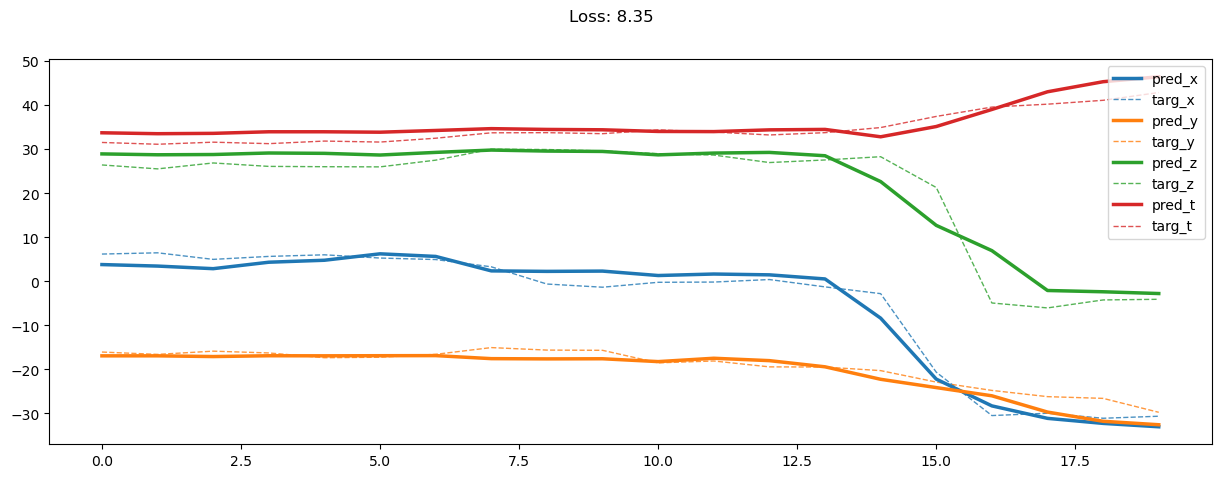

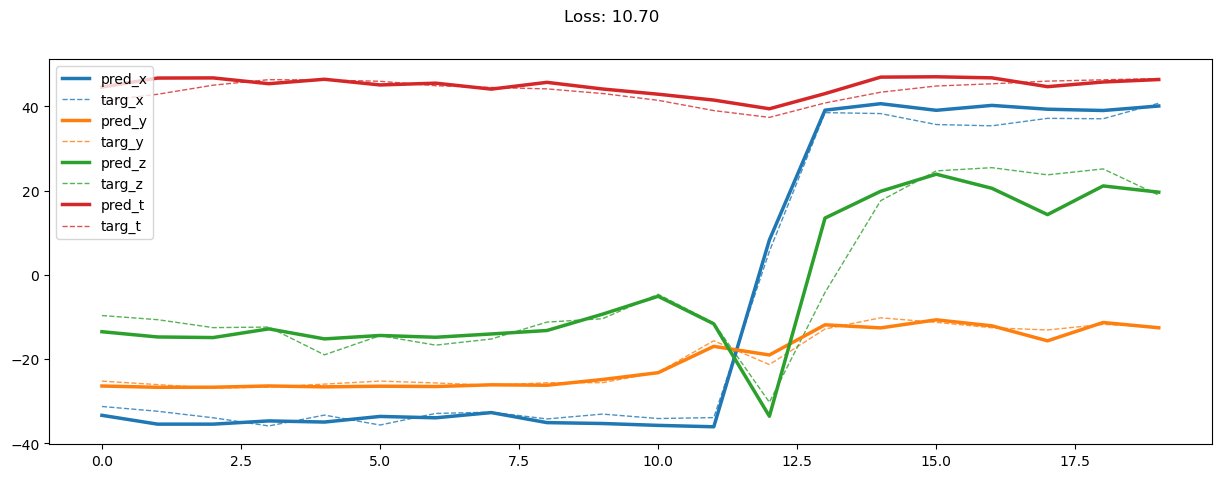

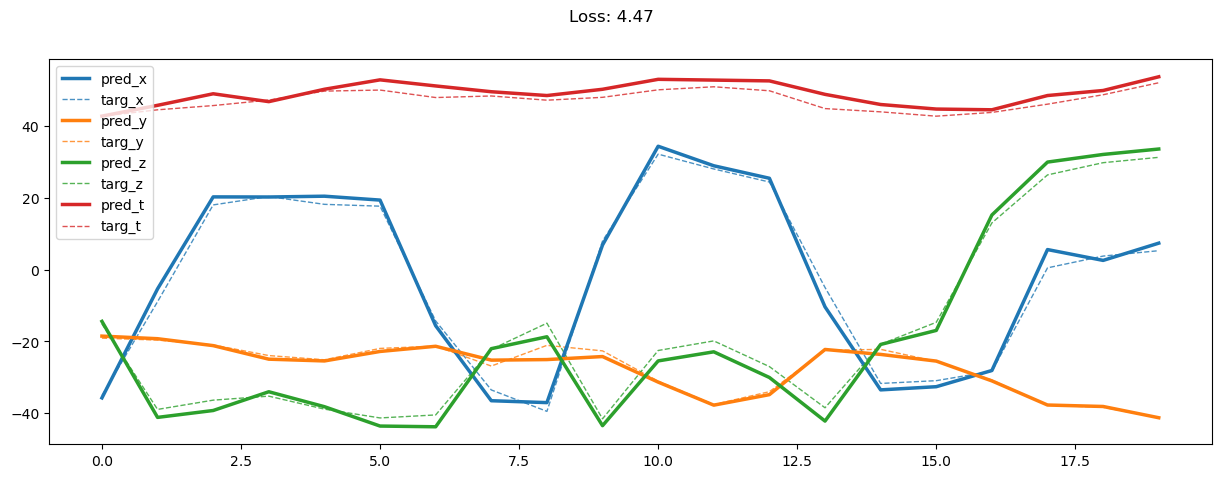

In [56]:
show_result(model, valid_loader)

In [57]:
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

In [58]:
rotation = False
num_of_axie = 3
gt = 'pocket'

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

{1: 'front_pocket', 2: 'horizontal', 0: 'pocket', 3: 'swing', 4: 'target'}


100%|██████████████████████████████████████████████████████████████████████████▉| 19999/20000 [2:49:39<00:00,  5.20it/s]

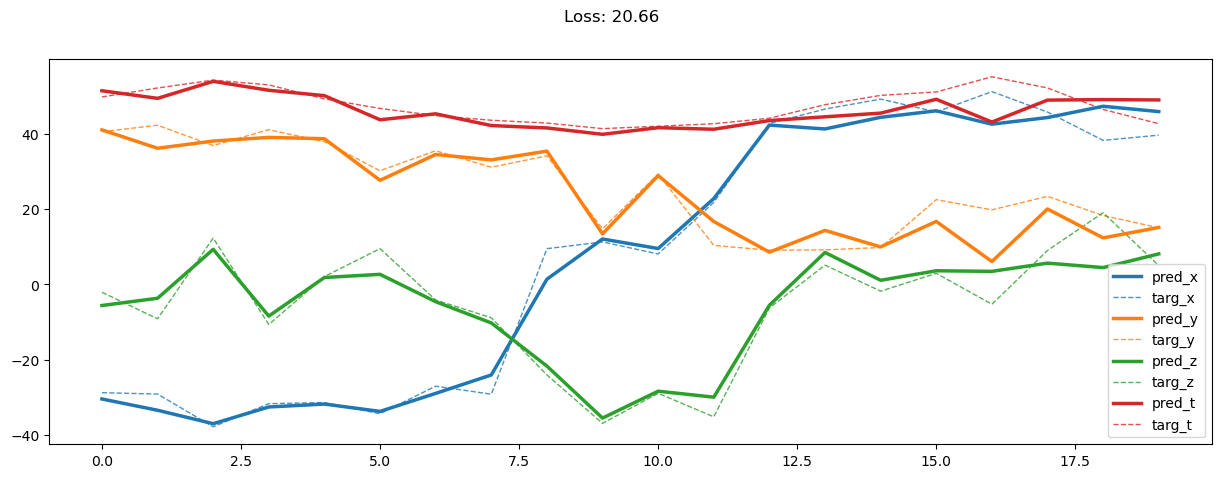

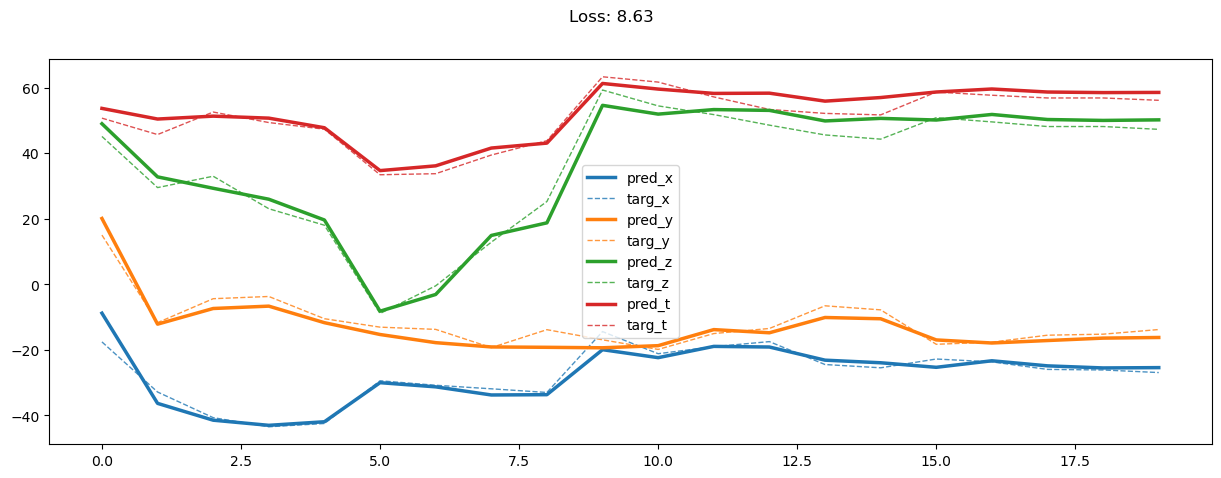

100%|███████████████████████████████████████████████████████████████████████████| 20000/20000 [2:49:40<00:00,  1.96it/s]

19999: train loss: 100.382, imu loss:  2.066, mag loss: 31.659, div loss: 63.453, slim:  4.996, tlim:  2.607
       valid loss: 51.807, imu loss:  1.920, mag loss: 16.604, div loss: 30.519, slim:  5.272, tlim:  1.927


In [59]:
EPOCH = 20000
draw = False

for epoch in tqdm(range(EPOCH)):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    draw = ((epoch + 1) % 20000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    
    if (epoch + 1) % 20000 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>6.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>6.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

(1348, 4) (1348, 3) (1348,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    15.56    11.94    16.26    14.58
     horizontal loss:    29.93    12.76    20.22    20.97
          swing loss:     7.73     6.36     8.11     7.40
         target loss:    20.06    11.73    19.42    17.07
        average loss:    18.32    10.70    16.00    15.01


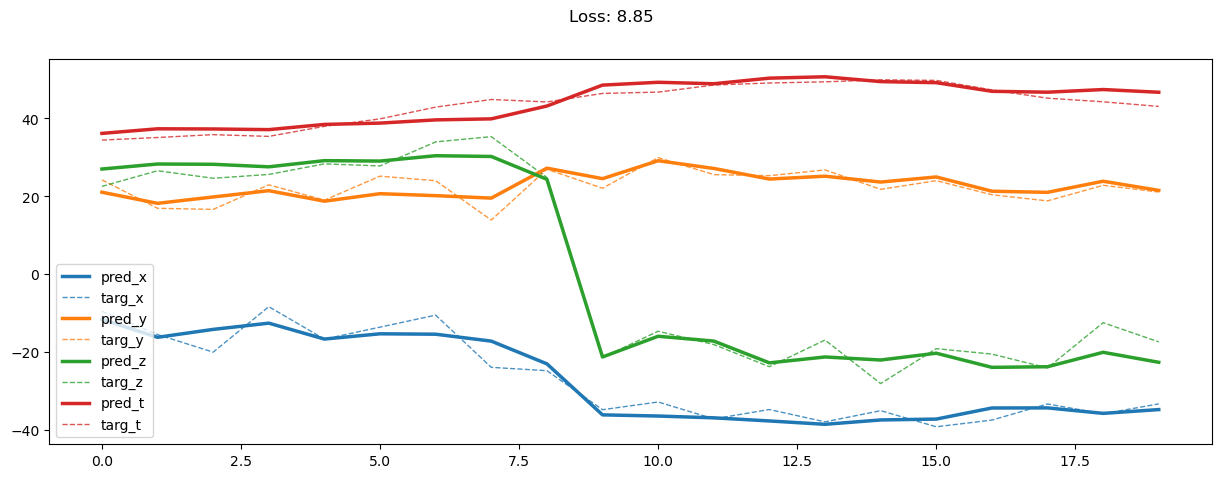

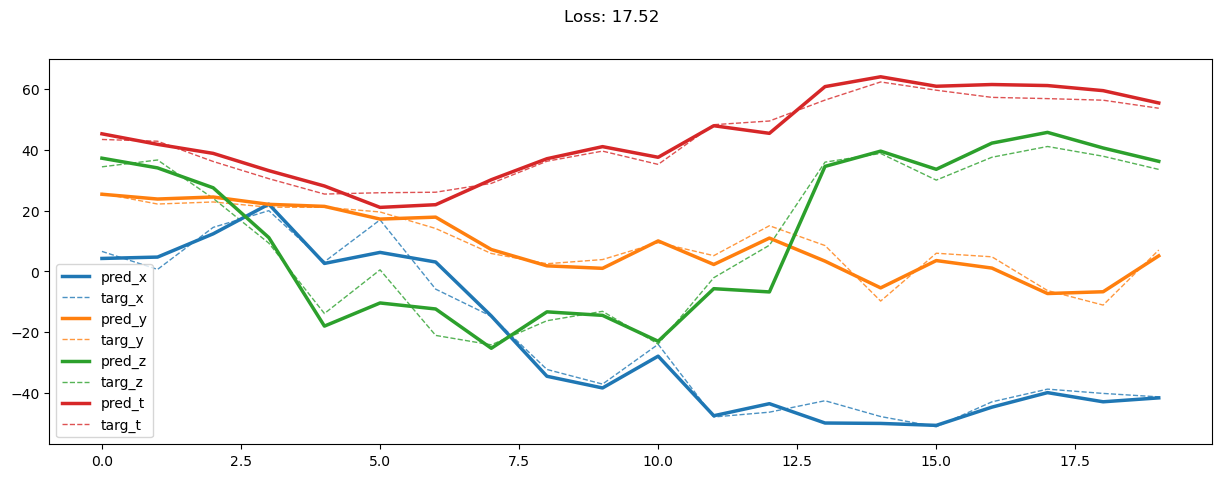

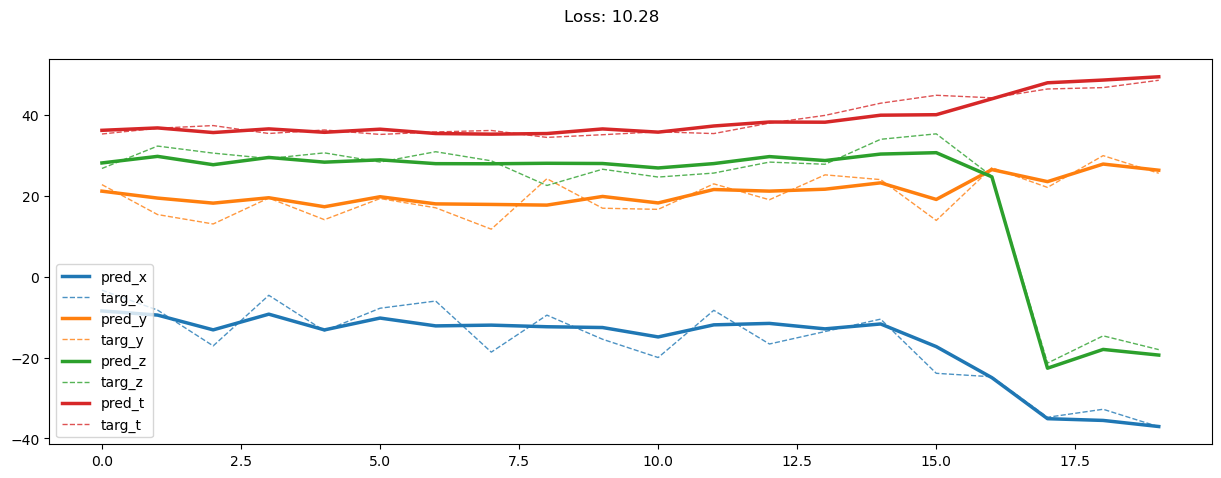

In [60]:
show_result(model, train_loader)

(1348, 4) (1348, 3) (1348,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:    18.09    13.01    17.97    16.35
     horizontal loss:    30.53    13.53    21.23    21.76
          swing loss:     9.97     7.36     9.88     9.07
         target loss:    21.67    12.25    20.35    18.09
        average loss:    20.06    11.54    17.36    16.32


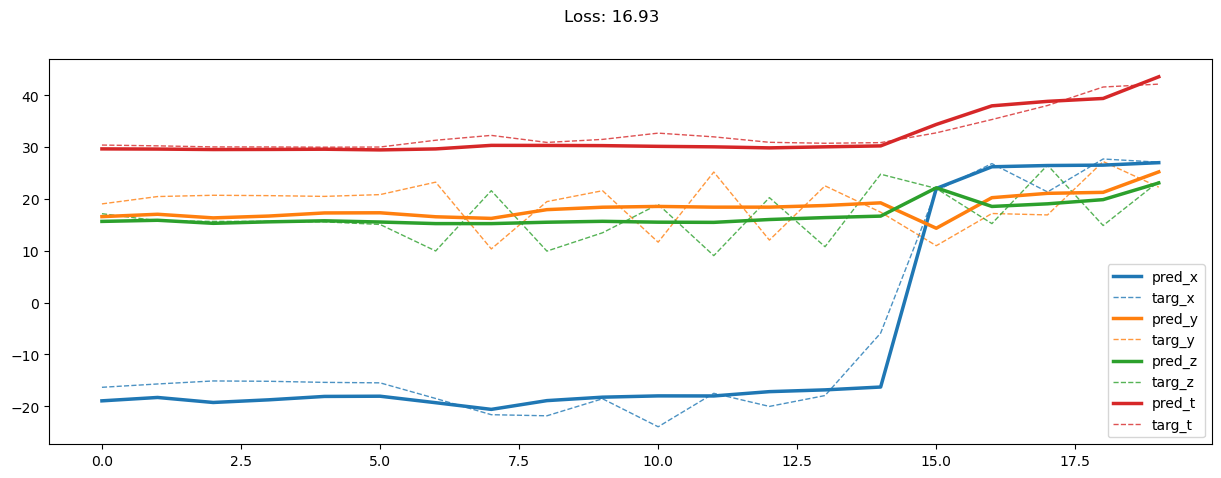

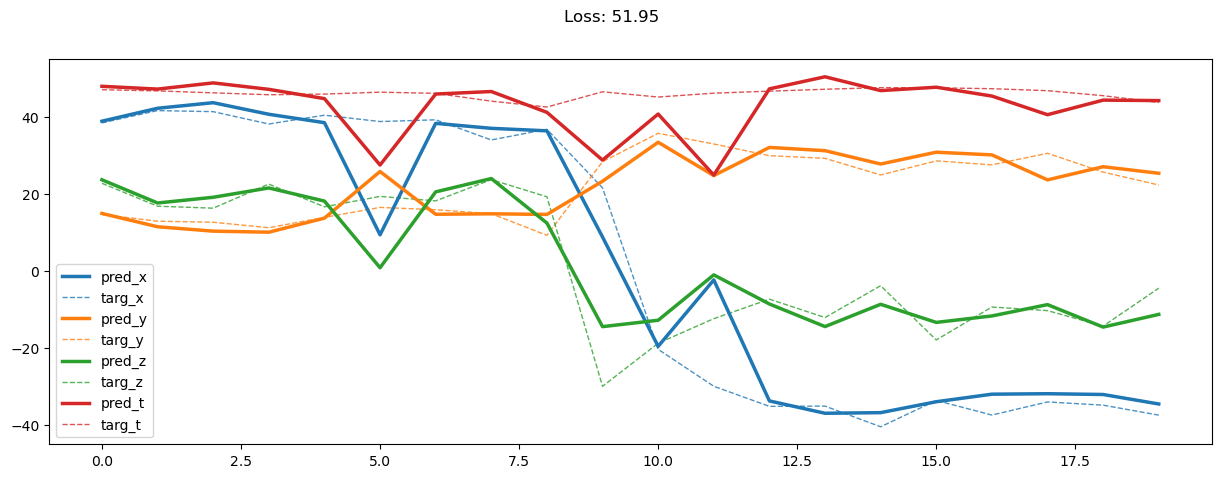

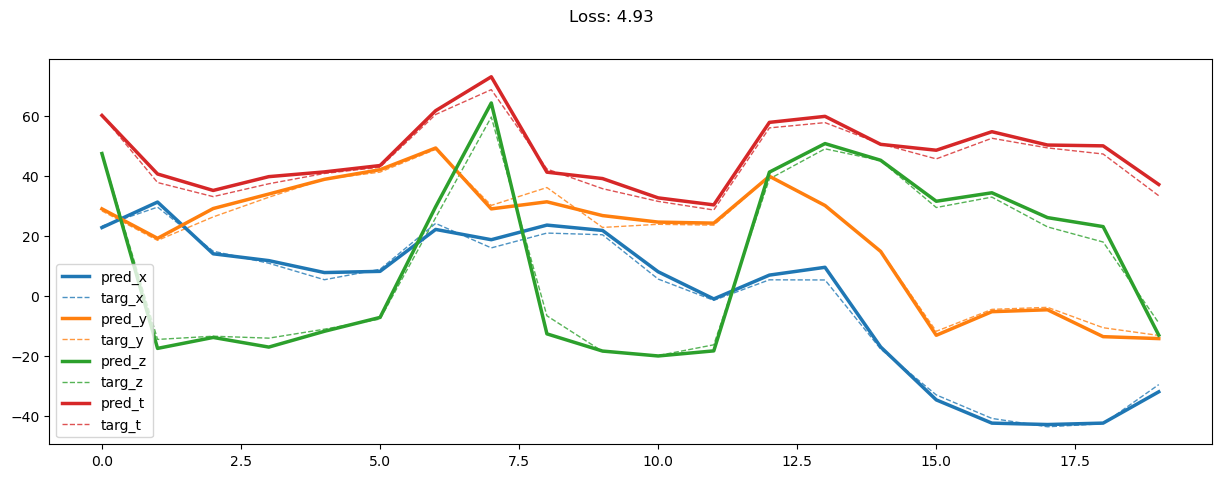

In [61]:
show_result(model, valid_loader)

In [62]:
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()

In [63]:
rotation = False
num_of_axie = 3
gt = 'swing'

classes, train_dataset, valid_dataset = for_dataloaders(prep_valid_traj, gt)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)

model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)

{1: 'front_pocket', 2: 'horizontal', 3: 'pocket', 0: 'swing', 4: 'target'}


In [ ]:
EPOCH = 20000
draw = False

for epoch in tqdm(range(EPOCH)):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    draw = ((epoch + 1) % 20000 == 0)
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    
    if (epoch + 1) % 20000 == 0:
        valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
        print(f'{epoch:05d}: train loss: {train_loss:>6.3f}, imu loss: {train_imu_loss:>6.3f}, mag loss: {train_mag_loss:>6.3f}, div loss: {t_d1_loss:>6.3f}, slim: {tlim_loss[0]:>6.3f}, tlim: {tlim_loss[1]:>6.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss:>6.3f}, imu loss: {valid_imu_loss:>6.3f}, mag loss: {valid_mag_loss:>6.3f}, div loss: {v_d1_loss:>6.3f}, slim: {vlim_loss[0]:>6.3f}, tlim: {vlim_loss[1]:>6.3f}')

 92%|████████████████████████████████████████████████████████████████████▊      | 18339/20000 [2:46:01<15:35,  1.78it/s]

In [ ]:
show_result(model, train_loader)

In [ ]:
show_result(model, valid_loader)

In [ ]:
model.cpu()
del model, optimizer, train_loader, valid_loader, train_dataset, valid_dataset
gc.collect()
torch.cuda.empty_cache()